In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/3_Temporal_Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, MyRandomAgent, run_experiment_episode_train

### Run locally

In [3]:
from rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, MyRandomAgent, run_experiment_episode_train

/home/raphael/rl_introduction/venv/lib/python3.7/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()



# 3_Temporal_Difference

### Objective
Here we present methods to solve the problem of environment and agents when the model is not known.

### Evaluate and train the agent

In [4]:
import numpy as np
import gym
import matplotlib.pyplot as plt
env = gym.make('FrozenLake-v1')

run_experiment_episode_train will be the function used to interact and learn from environment

In [5]:
def run_experiment_episode_train(env, agent, nb_episode, is_train=True):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            if is_train:
                agent.train(current_state, action, reward, state, done) # agent need a train method
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

In [6]:
class Example_of_trainable_agent:
    def __init__(self, env):
        self.env = env
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def act(self, state):
        action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action
    def train(self, current_state, action, reward, state, done):
        pass # do something smart to improve the policy

In [7]:
demo_agent = Example_of_trainable_agent(env)
run_experiment_episode_train(env, demo_agent, nb_episode=10, is_train=True)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Simplest exploration
Without knowing the model, we improve the policy by interacting with the environment. We start with an arbitrary policy, a major problem is caused by a local maximum due to insufficient exploration. To avoid it, we force the agent to act sometimes in a random way (control by an epsilon).

Until we are not confident of our evaluation of $Q$ we don't know if choising $\pi(s) = \max_a Q_\pi(s,a)$ will bring to a better policy.

It gives us Epsilon-Greedy policy $\pi(s) = \max_a Q_\pi(s,a)$ with probability $1-\epsilon$ any other action with probability $\epsilon$

In [31]:
#check!
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [12]:
def train(self, current_state, action, reward, state, done):
    self.q = evalution_of_Q()
    for state in range(env.observation_space.n): # update policy
        self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)
    def act(self, state):
        action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

# Usefull tools
Many times, it will be necessary to calculate the discount return $G_t = \sum_{k=0}^T\gamma^k R_{t+k+1}$. For that, we use optimized discount_cumsum function. Example

In [13]:
episode_reward = [0,0,0,1,0,0,0,-.3,0,1,1,0,10]
gamma = 0.99
discount_cumsum(episode_reward, gamma)

array([11.37242744, 11.48730044, 11.60333378, 11.72053917, 10.82882744,
       10.93820954, 11.0486965 , 11.1602995 , 11.5760601 , 11.69299   ,
       10.801     ,  9.9       , 10.        ])

In many cases, we will need to compute the disount rewards through multiple episodes:

### TODO 1): compute G along episodes

In [14]:
#TODO: compute G along episodes for a random agent (action = env.action_space.sample())
def get_G(env, gamma=0.99, nb_episode=500):
    return discount_returns
# It should return the list of discounted return through multiple episodes.
# Example:
# gamma=1
# nb_episode=2
# episode_reward1 = [1,2,3]
# episode_reward2 = [-1,0,1,4]
# return = [6., 5., 3., 4., 5., 5., 4.]

In [16]:
res = get_G(env)
res

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

And to compute the trajectories $(S,A,R,G)_\pi$:

### TODO 2): compute trajectory along episode

In [17]:
#TODO: compute trajectory along episode for a random agent (action = env.action_space.sample())
def get_trajectories(env, gamma=0.99, nb_episode=50):
    return trajectories
# It should return the list of S_t, A_t, R_{t+1}, G_t through multiple episodes.
# Example:
# gamma=1
# nb_episode=2
# episode_reward1 = [1,2,3]
# episode_state1 = ['s1', 's2', 's1'] 
# episode_action1 = ['a1', 'a2', 'a1'] 
# episode_reward2 = [-1,0,1,4]
# episode_state2 = ['s1', 's2', 's3', 's2'] 
# episode_action2 = ['a1', 'a2', 'a3', 'a3'] 
# return = [['s1', 'a1', 1, 6.],
#           ['s2', 'a2', 2, 5.],
#           ['s1', 'a1', 3, 3.],
#           ['s1', 'a1', -1, 4.],
#           ['s2',' a2', 0, 5.],
#           ['s3', 'a3', 1, 5.],
#           ['s2', 'a3', 4, 4.]]

In [19]:
res = get_trajectories(env)
res.shape
#print('states' : res[:,0])
#print('actions' : res[:,1])
#print('rewards' : res[:,2])
#print('cumulative discounted rewards' : res[:,3])

(419, 4)

In [20]:
res

array([[0., 0., 2., 0.],
       [0., 4., 3., 0.],
       [0., 4., 1., 0.],
       ...,
       [0., 0., 2., 0.],
       [0., 0., 2., 0.],
       [0., 4., 3., 0.]])

# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}

Remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N_{\text{total}}(S_t)}(G_t - N_{\text{trajectory}}(S_t)V(S_t))\\
\end{aligned}

### TODO 3): complete policy MC evaluation step

In [21]:
#TODO: complete policy MC evaluation step
# It should evaluate and return the value function for all state for an agent
# initialize value function
# 1) Compute an episode (cumulative reward, N_{total}, N_{trajectory})
# 2) For each state update the value function using incremental mean
# 3) go back to 1
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    return V

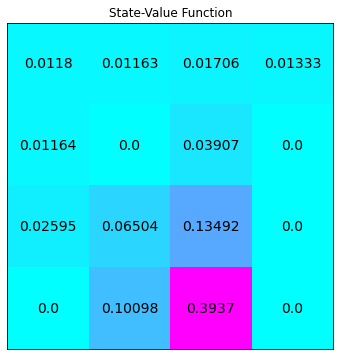

In [23]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

In [24]:
V.sum()

0.8251166557737017

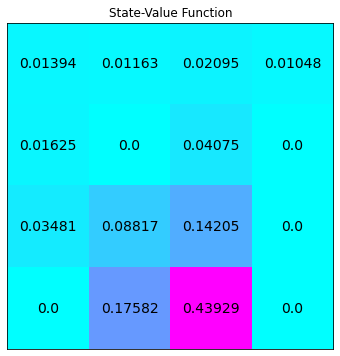

In [25]:
# In reality, here we know the model, we use it to control our results
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy) #see II) dynamic-programming
plot_values_lake(V)

In [26]:
V.sum()

0.9941411498416601

In the same way, we estimate the Q function. 

For Q evaluation
\begin{aligned}
Q(A_t, S_t) &\leftarrow Q(A_t, S_t) + \frac{1}{N_{\text{total}}(A_t, S_t)}(G_t - N_{\text{trajectory}}(A_t, S_t)Q(A_t, S_t))\\
\end{aligned}

And we train an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

### Train Monte-Carlo agent

### TODO 4): complete policy MC algo

In [28]:
### TODO 4): complete policy MC algo
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n])
        # add the value you need (episode, N_{total}, N_{trajectory})
    def train(self, current_state, action, reward, next_state, done):
        # collect trajectories
        # update N_{total}, N_{trajectory}
        if done is True: # we train the agent at every end of episode
        # evaluate Q
            for state in range(env.observation_space.n): # update policy
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 340 - cum reward 0.0
episode: 341 - cum reward 0.0
episode: 342 - cum reward 0.0
episode: 343 - cum reward 0.0
episode: 344 - cum reward 0.0
episode: 345 - cum reward 0.0
episode: 346 - cum reward 0.0
episode: 347 - cum reward 0.0
episode: 348 - cum reward 0.0
episode: 349 - cum reward 0.0
episode: 350 - cum reward 0.0
episode: 351 - cum reward 0.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 1.0
episode: 354 - cum reward 0.0
episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 1.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 3

episode: 756 - cum reward 0.0
episode: 757 - cum reward 0.0
episode: 758 - cum reward 0.0
episode: 759 - cum reward 0.0
episode: 760 - cum reward 0.0
episode: 761 - cum reward 0.0
episode: 762 - cum reward 0.0
episode: 763 - cum reward 0.0
episode: 764 - cum reward 0.0
episode: 765 - cum reward 0.0
episode: 766 - cum reward 1.0
episode: 767 - cum reward 0.0
episode: 768 - cum reward 0.0
episode: 769 - cum reward 0.0
episode: 770 - cum reward 0.0
episode: 771 - cum reward 0.0
episode: 772 - cum reward 0.0
episode: 773 - cum reward 0.0
episode: 774 - cum reward 0.0
episode: 775 - cum reward 0.0
episode: 776 - cum reward 0.0
episode: 777 - cum reward 1.0
episode: 778 - cum reward 0.0
episode: 779 - cum reward 0.0
episode: 780 - cum reward 0.0
episode: 781 - cum reward 0.0
episode: 782 - cum reward 0.0
episode: 783 - cum reward 0.0
episode: 784 - cum reward 0.0
episode: 785 - cum reward 0.0
episode: 786 - cum reward 0.0
episode: 787 - cum reward 0.0
episode: 788 - cum reward 0.0
episode: 7

episode: 1079 - cum reward 0.0
episode: 1080 - cum reward 0.0
episode: 1081 - cum reward 1.0
episode: 1082 - cum reward 0.0
episode: 1083 - cum reward 0.0
episode: 1084 - cum reward 0.0
episode: 1085 - cum reward 0.0
episode: 1086 - cum reward 0.0
episode: 1087 - cum reward 0.0
episode: 1088 - cum reward 0.0
episode: 1089 - cum reward 0.0
episode: 1090 - cum reward 0.0
episode: 1091 - cum reward 0.0
episode: 1092 - cum reward 0.0
episode: 1093 - cum reward 0.0
episode: 1094 - cum reward 0.0
episode: 1095 - cum reward 1.0
episode: 1096 - cum reward 0.0
episode: 1097 - cum reward 1.0
episode: 1098 - cum reward 0.0
episode: 1099 - cum reward 0.0
episode: 1100 - cum reward 0.0
episode: 1101 - cum reward 0.0
episode: 1102 - cum reward 0.0
episode: 1103 - cum reward 1.0
episode: 1104 - cum reward 0.0
episode: 1105 - cum reward 0.0
episode: 1106 - cum reward 1.0
episode: 1107 - cum reward 0.0
episode: 1108 - cum reward 0.0
episode: 1109 - cum reward 0.0
episode: 1110 - cum reward 0.0
episode:

episode: 1474 - cum reward 0.0
episode: 1475 - cum reward 0.0
episode: 1476 - cum reward 0.0
episode: 1477 - cum reward 0.0
episode: 1478 - cum reward 0.0
episode: 1479 - cum reward 0.0
episode: 1480 - cum reward 0.0
episode: 1481 - cum reward 0.0
episode: 1482 - cum reward 0.0
episode: 1483 - cum reward 0.0
episode: 1484 - cum reward 0.0
episode: 1485 - cum reward 0.0
episode: 1486 - cum reward 1.0
episode: 1487 - cum reward 0.0
episode: 1488 - cum reward 0.0
episode: 1489 - cum reward 0.0
episode: 1490 - cum reward 0.0
episode: 1491 - cum reward 0.0
episode: 1492 - cum reward 0.0
episode: 1493 - cum reward 0.0
episode: 1494 - cum reward 0.0
episode: 1495 - cum reward 0.0
episode: 1496 - cum reward 0.0
episode: 1497 - cum reward 0.0
episode: 1498 - cum reward 0.0
episode: 1499 - cum reward 0.0
episode: 1500 - cum reward 0.0
episode: 1501 - cum reward 1.0
episode: 1502 - cum reward 0.0
episode: 1503 - cum reward 0.0
episode: 1504 - cum reward 0.0
episode: 1505 - cum reward 0.0
episode:

episode: 1875 - cum reward 0.0
episode: 1876 - cum reward 1.0
episode: 1877 - cum reward 0.0
episode: 1878 - cum reward 0.0
episode: 1879 - cum reward 0.0
episode: 1880 - cum reward 0.0
episode: 1881 - cum reward 0.0
episode: 1882 - cum reward 1.0
episode: 1883 - cum reward 0.0
episode: 1884 - cum reward 1.0
episode: 1885 - cum reward 0.0
episode: 1886 - cum reward 0.0
episode: 1887 - cum reward 0.0
episode: 1888 - cum reward 1.0
episode: 1889 - cum reward 0.0
episode: 1890 - cum reward 0.0
episode: 1891 - cum reward 0.0
episode: 1892 - cum reward 0.0
episode: 1893 - cum reward 1.0
episode: 1894 - cum reward 0.0
episode: 1895 - cum reward 0.0
episode: 1896 - cum reward 1.0
episode: 1897 - cum reward 0.0
episode: 1898 - cum reward 0.0
episode: 1899 - cum reward 0.0
episode: 1900 - cum reward 0.0
episode: 1901 - cum reward 0.0
episode: 1902 - cum reward 0.0
episode: 1903 - cum reward 0.0
episode: 1904 - cum reward 0.0
episode: 1905 - cum reward 0.0
episode: 1906 - cum reward 0.0
episode:

episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 0.0
episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 1.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 0.0
episode: 2306 - cum reward 0.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 0.0
episode: 2309 - cum reward 1.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 0.0
episode: 2314 - cum reward 0.0
episode: 2315 - cum reward 0.0
episode: 2316 - cum reward 0.0
episode: 2317 - cum reward 0.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 0.0
episode: 2320 - cum reward 0.0
episode: 2321 - cum reward 0.0
episode: 2322 - cum reward 0.0
episode: 2323 - cum reward 0.0
episode: 2324 - cum reward 0.0
episode: 2325 - cum reward 0.0
episode: 2326 - cum reward 0.0
episode: 2327 - cum reward 0.0
episode: 2328 - cum reward 0.0
episode:

episode: 2710 - cum reward 0.0
episode: 2711 - cum reward 0.0
episode: 2712 - cum reward 0.0
episode: 2713 - cum reward 0.0
episode: 2714 - cum reward 0.0
episode: 2715 - cum reward 0.0
episode: 2716 - cum reward 0.0
episode: 2717 - cum reward 0.0
episode: 2718 - cum reward 0.0
episode: 2719 - cum reward 0.0
episode: 2720 - cum reward 0.0
episode: 2721 - cum reward 0.0
episode: 2722 - cum reward 0.0
episode: 2723 - cum reward 1.0
episode: 2724 - cum reward 0.0
episode: 2725 - cum reward 0.0
episode: 2726 - cum reward 0.0
episode: 2727 - cum reward 0.0
episode: 2728 - cum reward 0.0
episode: 2729 - cum reward 0.0
episode: 2730 - cum reward 0.0
episode: 2731 - cum reward 0.0
episode: 2732 - cum reward 0.0
episode: 2733 - cum reward 0.0
episode: 2734 - cum reward 0.0
episode: 2735 - cum reward 0.0
episode: 2736 - cum reward 1.0
episode: 2737 - cum reward 0.0
episode: 2738 - cum reward 0.0
episode: 2739 - cum reward 0.0
episode: 2740 - cum reward 0.0
episode: 2741 - cum reward 1.0
episode:

episode: 3094 - cum reward 0.0
episode: 3095 - cum reward 0.0
episode: 3096 - cum reward 0.0
episode: 3097 - cum reward 0.0
episode: 3098 - cum reward 0.0
episode: 3099 - cum reward 0.0
episode: 3100 - cum reward 0.0
episode: 3101 - cum reward 0.0
episode: 3102 - cum reward 0.0
episode: 3103 - cum reward 0.0
episode: 3104 - cum reward 0.0
episode: 3105 - cum reward 0.0
episode: 3106 - cum reward 0.0
episode: 3107 - cum reward 0.0
episode: 3108 - cum reward 0.0
episode: 3109 - cum reward 0.0
episode: 3110 - cum reward 0.0
episode: 3111 - cum reward 0.0
episode: 3112 - cum reward 0.0
episode: 3113 - cum reward 1.0
episode: 3114 - cum reward 0.0
episode: 3115 - cum reward 0.0
episode: 3116 - cum reward 1.0
episode: 3117 - cum reward 0.0
episode: 3118 - cum reward 0.0
episode: 3119 - cum reward 0.0
episode: 3120 - cum reward 0.0
episode: 3121 - cum reward 0.0
episode: 3122 - cum reward 0.0
episode: 3123 - cum reward 0.0
episode: 3124 - cum reward 0.0
episode: 3125 - cum reward 0.0
episode:

episode: 3490 - cum reward 0.0
episode: 3491 - cum reward 0.0
episode: 3492 - cum reward 0.0
episode: 3493 - cum reward 0.0
episode: 3494 - cum reward 0.0
episode: 3495 - cum reward 1.0
episode: 3496 - cum reward 0.0
episode: 3497 - cum reward 0.0
episode: 3498 - cum reward 0.0
episode: 3499 - cum reward 1.0
episode: 3500 - cum reward 1.0
episode: 3501 - cum reward 1.0
episode: 3502 - cum reward 0.0
episode: 3503 - cum reward 0.0
episode: 3504 - cum reward 1.0
episode: 3505 - cum reward 1.0
episode: 3506 - cum reward 0.0
episode: 3507 - cum reward 0.0
episode: 3508 - cum reward 1.0
episode: 3509 - cum reward 0.0
episode: 3510 - cum reward 0.0
episode: 3511 - cum reward 0.0
episode: 3512 - cum reward 0.0
episode: 3513 - cum reward 0.0
episode: 3514 - cum reward 0.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode: 3517 - cum reward 0.0
episode: 3518 - cum reward 0.0
episode: 3519 - cum reward 0.0
episode: 3520 - cum reward 1.0
episode: 3521 - cum reward 0.0
episode:

episode: 3836 - cum reward 0.0
episode: 3837 - cum reward 0.0
episode: 3838 - cum reward 0.0
episode: 3839 - cum reward 0.0
episode: 3840 - cum reward 0.0
episode: 3841 - cum reward 1.0
episode: 3842 - cum reward 0.0
episode: 3843 - cum reward 0.0
episode: 3844 - cum reward 0.0
episode: 3845 - cum reward 0.0
episode: 3846 - cum reward 0.0
episode: 3847 - cum reward 0.0
episode: 3848 - cum reward 0.0
episode: 3849 - cum reward 0.0
episode: 3850 - cum reward 0.0
episode: 3851 - cum reward 1.0
episode: 3852 - cum reward 0.0
episode: 3853 - cum reward 0.0
episode: 3854 - cum reward 1.0
episode: 3855 - cum reward 0.0
episode: 3856 - cum reward 0.0
episode: 3857 - cum reward 0.0
episode: 3858 - cum reward 0.0
episode: 3859 - cum reward 0.0
episode: 3860 - cum reward 0.0
episode: 3861 - cum reward 1.0
episode: 3862 - cum reward 0.0
episode: 3863 - cum reward 1.0
episode: 3864 - cum reward 0.0
episode: 3865 - cum reward 1.0
episode: 3866 - cum reward 1.0
episode: 3867 - cum reward 0.0
episode:

episode: 4118 - cum reward 0.0
episode: 4119 - cum reward 0.0
episode: 4120 - cum reward 0.0
episode: 4121 - cum reward 0.0
episode: 4122 - cum reward 0.0
episode: 4123 - cum reward 0.0
episode: 4124 - cum reward 0.0
episode: 4125 - cum reward 1.0
episode: 4126 - cum reward 0.0
episode: 4127 - cum reward 1.0
episode: 4128 - cum reward 0.0
episode: 4129 - cum reward 0.0
episode: 4130 - cum reward 0.0
episode: 4131 - cum reward 0.0
episode: 4132 - cum reward 0.0
episode: 4133 - cum reward 0.0
episode: 4134 - cum reward 1.0
episode: 4135 - cum reward 0.0
episode: 4136 - cum reward 0.0
episode: 4137 - cum reward 0.0
episode: 4138 - cum reward 0.0
episode: 4139 - cum reward 0.0
episode: 4140 - cum reward 0.0
episode: 4141 - cum reward 0.0
episode: 4142 - cum reward 0.0
episode: 4143 - cum reward 0.0
episode: 4144 - cum reward 0.0
episode: 4145 - cum reward 0.0
episode: 4146 - cum reward 1.0
episode: 4147 - cum reward 1.0
episode: 4148 - cum reward 1.0
episode: 4149 - cum reward 0.0
episode:

episode: 4477 - cum reward 0.0
episode: 4478 - cum reward 0.0
episode: 4479 - cum reward 0.0
episode: 4480 - cum reward 0.0
episode: 4481 - cum reward 0.0
episode: 4482 - cum reward 0.0
episode: 4483 - cum reward 0.0
episode: 4484 - cum reward 0.0
episode: 4485 - cum reward 1.0
episode: 4486 - cum reward 1.0
episode: 4487 - cum reward 0.0
episode: 4488 - cum reward 1.0
episode: 4489 - cum reward 0.0
episode: 4490 - cum reward 0.0
episode: 4491 - cum reward 0.0
episode: 4492 - cum reward 0.0
episode: 4493 - cum reward 0.0
episode: 4494 - cum reward 0.0
episode: 4495 - cum reward 1.0
episode: 4496 - cum reward 0.0
episode: 4497 - cum reward 1.0
episode: 4498 - cum reward 0.0
episode: 4499 - cum reward 0.0
episode: 4500 - cum reward 0.0
episode: 4501 - cum reward 0.0
episode: 4502 - cum reward 0.0
episode: 4503 - cum reward 0.0
episode: 4504 - cum reward 0.0
episode: 4505 - cum reward 0.0
episode: 4506 - cum reward 0.0
episode: 4507 - cum reward 0.0
episode: 4508 - cum reward 0.0
episode:

episode: 4819 - cum reward 0.0
episode: 4820 - cum reward 0.0
episode: 4821 - cum reward 0.0
episode: 4822 - cum reward 0.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 1.0
episode: 4825 - cum reward 1.0
episode: 4826 - cum reward 0.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 0.0
episode: 4829 - cum reward 0.0
episode: 4830 - cum reward 0.0
episode: 4831 - cum reward 0.0
episode: 4832 - cum reward 0.0
episode: 4833 - cum reward 0.0
episode: 4834 - cum reward 0.0
episode: 4835 - cum reward 0.0
episode: 4836 - cum reward 0.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 0.0
episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 0.0
episode: 4841 - cum reward 0.0
episode: 4842 - cum reward 0.0
episode: 4843 - cum reward 0.0
episode: 4844 - cum reward 0.0
episode: 4845 - cum reward 0.0
episode: 4846 - cum reward 0.0
episode: 4847 - cum reward 0.0
episode: 4848 - cum reward 0.0
episode: 4849 - cum reward 0.0
episode: 4850 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - mc_agent')

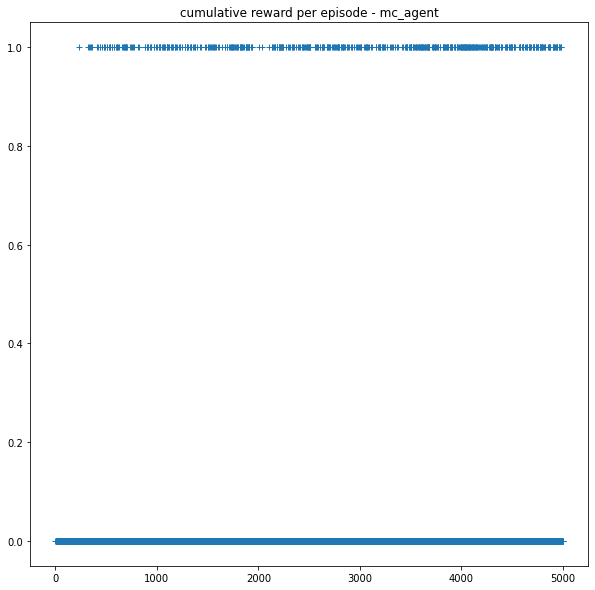

In [33]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - mc_agent')

In [34]:
mc_agent.policy

array([[0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

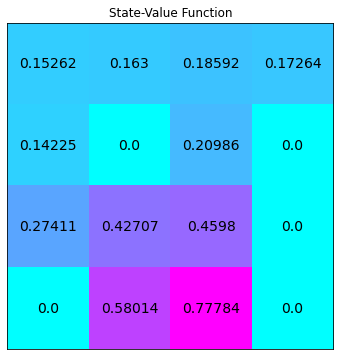

In [35]:
V = policy_evaluation(env, mc_agent.policy)
plot_values_lake(V)

In [36]:
V.sum()

3.5452384759535915

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
Using bellman equation $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$, That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

### TODO 5): complete policy td evaluation step

In [39]:
#TODO: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = None #complete here reward + gamma * V[state]
            td_error = None #complete here target - V[current_state]
            V[current_state] += None #complete here
    return V

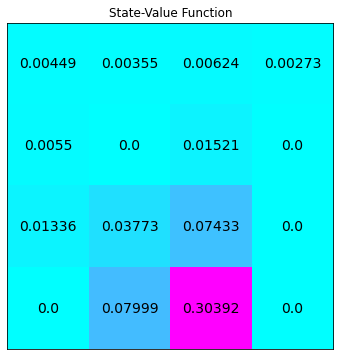

In [41]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

### TODO 5): complete SARSA agent

In [43]:
### TODO 5): complete SARSA agent
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n       
    def train(self, current_state, action, reward, next_state, done):
        # TRAIN SARSA
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 339 - cum reward 0.0
episode: 340 - cum reward 0.0
episode: 341 - cum reward 0.0
episode: 342 - cum reward 0.0
episode: 343 - cum reward 0.0
episode: 344 - cum reward 0.0
episode: 345 - cum reward 0.0
episode: 346 - cum reward 0.0
episode: 347 - cum reward 0.0
episode: 348 - cum reward 0.0
episode: 349 - cum reward 0.0
episode: 350 - cum reward 0.0
episode: 351 - cum reward 0.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 0.0
episode: 354 - cum reward 0.0
episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 3

episode: 674 - cum reward 0.0
episode: 675 - cum reward 0.0
episode: 676 - cum reward 0.0
episode: 677 - cum reward 0.0
episode: 678 - cum reward 0.0
episode: 679 - cum reward 0.0
episode: 680 - cum reward 0.0
episode: 681 - cum reward 0.0
episode: 682 - cum reward 0.0
episode: 683 - cum reward 0.0
episode: 684 - cum reward 0.0
episode: 685 - cum reward 0.0
episode: 686 - cum reward 0.0
episode: 687 - cum reward 0.0
episode: 688 - cum reward 0.0
episode: 689 - cum reward 0.0
episode: 690 - cum reward 0.0
episode: 691 - cum reward 0.0
episode: 692 - cum reward 0.0
episode: 693 - cum reward 0.0
episode: 694 - cum reward 0.0
episode: 695 - cum reward 0.0
episode: 696 - cum reward 0.0
episode: 697 - cum reward 0.0
episode: 698 - cum reward 0.0
episode: 699 - cum reward 0.0
episode: 700 - cum reward 0.0
episode: 701 - cum reward 0.0
episode: 702 - cum reward 0.0
episode: 703 - cum reward 0.0
episode: 704 - cum reward 0.0
episode: 705 - cum reward 0.0
episode: 706 - cum reward 0.0
episode: 7

episode: 974 - cum reward 0.0
episode: 975 - cum reward 0.0
episode: 976 - cum reward 0.0
episode: 977 - cum reward 0.0
episode: 978 - cum reward 0.0
episode: 979 - cum reward 0.0
episode: 980 - cum reward 0.0
episode: 981 - cum reward 0.0
episode: 982 - cum reward 0.0
episode: 983 - cum reward 1.0
episode: 984 - cum reward 0.0
episode: 985 - cum reward 0.0
episode: 986 - cum reward 1.0
episode: 987 - cum reward 0.0
episode: 988 - cum reward 0.0
episode: 989 - cum reward 0.0
episode: 990 - cum reward 0.0
episode: 991 - cum reward 0.0
episode: 992 - cum reward 0.0
episode: 993 - cum reward 0.0
episode: 994 - cum reward 0.0
episode: 995 - cum reward 0.0
episode: 996 - cum reward 0.0
episode: 997 - cum reward 0.0
episode: 998 - cum reward 0.0
episode: 999 - cum reward 0.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 0.0
episode: 1004 - cum reward 0.0
episode: 1005 - cum reward 0.0
episode: 1006 - cum reward 0.0
epi

episode: 1297 - cum reward 0.0
episode: 1298 - cum reward 0.0
episode: 1299 - cum reward 0.0
episode: 1300 - cum reward 0.0
episode: 1301 - cum reward 0.0
episode: 1302 - cum reward 0.0
episode: 1303 - cum reward 0.0
episode: 1304 - cum reward 0.0
episode: 1305 - cum reward 0.0
episode: 1306 - cum reward 0.0
episode: 1307 - cum reward 0.0
episode: 1308 - cum reward 0.0
episode: 1309 - cum reward 0.0
episode: 1310 - cum reward 0.0
episode: 1311 - cum reward 0.0
episode: 1312 - cum reward 0.0
episode: 1313 - cum reward 0.0
episode: 1314 - cum reward 0.0
episode: 1315 - cum reward 0.0
episode: 1316 - cum reward 0.0
episode: 1317 - cum reward 0.0
episode: 1318 - cum reward 0.0
episode: 1319 - cum reward 0.0
episode: 1320 - cum reward 0.0
episode: 1321 - cum reward 0.0
episode: 1322 - cum reward 0.0
episode: 1323 - cum reward 0.0
episode: 1324 - cum reward 0.0
episode: 1325 - cum reward 0.0
episode: 1326 - cum reward 0.0
episode: 1327 - cum reward 0.0
episode: 1328 - cum reward 0.0
episode:

episode: 1622 - cum reward 0.0
episode: 1623 - cum reward 0.0
episode: 1624 - cum reward 0.0
episode: 1625 - cum reward 0.0
episode: 1626 - cum reward 0.0
episode: 1627 - cum reward 0.0
episode: 1628 - cum reward 0.0
episode: 1629 - cum reward 0.0
episode: 1630 - cum reward 0.0
episode: 1631 - cum reward 0.0
episode: 1632 - cum reward 0.0
episode: 1633 - cum reward 0.0
episode: 1634 - cum reward 0.0
episode: 1635 - cum reward 0.0
episode: 1636 - cum reward 0.0
episode: 1637 - cum reward 0.0
episode: 1638 - cum reward 0.0
episode: 1639 - cum reward 0.0
episode: 1640 - cum reward 0.0
episode: 1641 - cum reward 0.0
episode: 1642 - cum reward 0.0
episode: 1643 - cum reward 0.0
episode: 1644 - cum reward 0.0
episode: 1645 - cum reward 0.0
episode: 1646 - cum reward 0.0
episode: 1647 - cum reward 0.0
episode: 1648 - cum reward 0.0
episode: 1649 - cum reward 0.0
episode: 1650 - cum reward 0.0
episode: 1651 - cum reward 0.0
episode: 1652 - cum reward 0.0
episode: 1653 - cum reward 0.0
episode:

episode: 1894 - cum reward 0.0
episode: 1895 - cum reward 0.0
episode: 1896 - cum reward 0.0
episode: 1897 - cum reward 0.0
episode: 1898 - cum reward 0.0
episode: 1899 - cum reward 0.0
episode: 1900 - cum reward 0.0
episode: 1901 - cum reward 0.0
episode: 1902 - cum reward 0.0
episode: 1903 - cum reward 0.0
episode: 1904 - cum reward 0.0
episode: 1905 - cum reward 0.0
episode: 1906 - cum reward 0.0
episode: 1907 - cum reward 0.0
episode: 1908 - cum reward 0.0
episode: 1909 - cum reward 0.0
episode: 1910 - cum reward 0.0
episode: 1911 - cum reward 0.0
episode: 1912 - cum reward 0.0
episode: 1913 - cum reward 0.0
episode: 1914 - cum reward 0.0
episode: 1915 - cum reward 0.0
episode: 1916 - cum reward 0.0
episode: 1917 - cum reward 0.0
episode: 1918 - cum reward 0.0
episode: 1919 - cum reward 0.0
episode: 1920 - cum reward 0.0
episode: 1921 - cum reward 0.0
episode: 1922 - cum reward 0.0
episode: 1923 - cum reward 0.0
episode: 1924 - cum reward 0.0
episode: 1925 - cum reward 0.0
episode:

episode: 2181 - cum reward 0.0
episode: 2182 - cum reward 0.0
episode: 2183 - cum reward 0.0
episode: 2184 - cum reward 0.0
episode: 2185 - cum reward 0.0
episode: 2186 - cum reward 0.0
episode: 2187 - cum reward 0.0
episode: 2188 - cum reward 0.0
episode: 2189 - cum reward 0.0
episode: 2190 - cum reward 0.0
episode: 2191 - cum reward 1.0
episode: 2192 - cum reward 0.0
episode: 2193 - cum reward 0.0
episode: 2194 - cum reward 0.0
episode: 2195 - cum reward 1.0
episode: 2196 - cum reward 0.0
episode: 2197 - cum reward 0.0
episode: 2198 - cum reward 0.0
episode: 2199 - cum reward 0.0
episode: 2200 - cum reward 0.0
episode: 2201 - cum reward 0.0
episode: 2202 - cum reward 0.0
episode: 2203 - cum reward 0.0
episode: 2204 - cum reward 0.0
episode: 2205 - cum reward 0.0
episode: 2206 - cum reward 0.0
episode: 2207 - cum reward 0.0
episode: 2208 - cum reward 0.0
episode: 2209 - cum reward 0.0
episode: 2210 - cum reward 0.0
episode: 2211 - cum reward 0.0
episode: 2212 - cum reward 0.0
episode:

episode: 2497 - cum reward 0.0
episode: 2498 - cum reward 0.0
episode: 2499 - cum reward 0.0
episode: 2500 - cum reward 0.0
episode: 2501 - cum reward 0.0
episode: 2502 - cum reward 0.0
episode: 2503 - cum reward 0.0
episode: 2504 - cum reward 0.0
episode: 2505 - cum reward 0.0
episode: 2506 - cum reward 0.0
episode: 2507 - cum reward 0.0
episode: 2508 - cum reward 0.0
episode: 2509 - cum reward 0.0
episode: 2510 - cum reward 0.0
episode: 2511 - cum reward 0.0
episode: 2512 - cum reward 0.0
episode: 2513 - cum reward 0.0
episode: 2514 - cum reward 0.0
episode: 2515 - cum reward 0.0
episode: 2516 - cum reward 0.0
episode: 2517 - cum reward 0.0
episode: 2518 - cum reward 0.0
episode: 2519 - cum reward 0.0
episode: 2520 - cum reward 0.0
episode: 2521 - cum reward 0.0
episode: 2522 - cum reward 0.0
episode: 2523 - cum reward 0.0
episode: 2524 - cum reward 0.0
episode: 2525 - cum reward 0.0
episode: 2526 - cum reward 0.0
episode: 2527 - cum reward 0.0
episode: 2528 - cum reward 0.0
episode:

episode: 2822 - cum reward 0.0
episode: 2823 - cum reward 0.0
episode: 2824 - cum reward 0.0
episode: 2825 - cum reward 0.0
episode: 2826 - cum reward 0.0
episode: 2827 - cum reward 0.0
episode: 2828 - cum reward 0.0
episode: 2829 - cum reward 0.0
episode: 2830 - cum reward 0.0
episode: 2831 - cum reward 0.0
episode: 2832 - cum reward 0.0
episode: 2833 - cum reward 0.0
episode: 2834 - cum reward 0.0
episode: 2835 - cum reward 0.0
episode: 2836 - cum reward 0.0
episode: 2837 - cum reward 0.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 0.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 0.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 0.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 0.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode:

episode: 3185 - cum reward 0.0
episode: 3186 - cum reward 0.0
episode: 3187 - cum reward 0.0
episode: 3188 - cum reward 0.0
episode: 3189 - cum reward 0.0
episode: 3190 - cum reward 0.0
episode: 3191 - cum reward 0.0
episode: 3192 - cum reward 0.0
episode: 3193 - cum reward 0.0
episode: 3194 - cum reward 0.0
episode: 3195 - cum reward 0.0
episode: 3196 - cum reward 0.0
episode: 3197 - cum reward 0.0
episode: 3198 - cum reward 0.0
episode: 3199 - cum reward 0.0
episode: 3200 - cum reward 0.0
episode: 3201 - cum reward 0.0
episode: 3202 - cum reward 0.0
episode: 3203 - cum reward 0.0
episode: 3204 - cum reward 0.0
episode: 3205 - cum reward 0.0
episode: 3206 - cum reward 0.0
episode: 3207 - cum reward 0.0
episode: 3208 - cum reward 0.0
episode: 3209 - cum reward 0.0
episode: 3210 - cum reward 0.0
episode: 3211 - cum reward 0.0
episode: 3212 - cum reward 1.0
episode: 3213 - cum reward 0.0
episode: 3214 - cum reward 0.0
episode: 3215 - cum reward 0.0
episode: 3216 - cum reward 0.0
episode:

episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode: 3517 - cum reward 0.0
episode: 3518 - cum reward 0.0
episode: 3519 - cum reward 0.0
episode: 3520 - cum reward 0.0
episode: 3521 - cum reward 0.0
episode: 3522 - cum reward 0.0
episode: 3523 - cum reward 0.0
episode: 3524 - cum reward 0.0
episode: 3525 - cum reward 0.0
episode: 3526 - cum reward 0.0
episode: 3527 - cum reward 0.0
episode: 3528 - cum reward 0.0
episode: 3529 - cum reward 0.0
episode: 3530 - cum reward 0.0
episode: 3531 - cum reward 0.0
episode: 3532 - cum reward 0.0
episode: 3533 - cum reward 0.0
episode: 3534 - cum reward 0.0
episode: 3535 - cum reward 0.0
episode: 3536 - cum reward 0.0
episode: 3537 - cum reward 0.0
episode: 3538 - cum reward 0.0
episode: 3539 - cum reward 0.0
episode: 3540 - cum reward 0.0
episode: 3541 - cum reward 0.0
episode: 3542 - cum reward 0.0
episode: 3543 - cum reward 0.0
episode: 3544 - cum reward 0.0
episode: 3545 - cum reward 0.0
episode: 3546 - cum reward 0.0
episode:

episode: 3857 - cum reward 0.0
episode: 3858 - cum reward 0.0
episode: 3859 - cum reward 0.0
episode: 3860 - cum reward 0.0
episode: 3861 - cum reward 0.0
episode: 3862 - cum reward 0.0
episode: 3863 - cum reward 0.0
episode: 3864 - cum reward 0.0
episode: 3865 - cum reward 0.0
episode: 3866 - cum reward 0.0
episode: 3867 - cum reward 0.0
episode: 3868 - cum reward 0.0
episode: 3869 - cum reward 0.0
episode: 3870 - cum reward 0.0
episode: 3871 - cum reward 0.0
episode: 3872 - cum reward 0.0
episode: 3873 - cum reward 0.0
episode: 3874 - cum reward 0.0
episode: 3875 - cum reward 0.0
episode: 3876 - cum reward 1.0
episode: 3877 - cum reward 1.0
episode: 3878 - cum reward 1.0
episode: 3879 - cum reward 0.0
episode: 3880 - cum reward 0.0
episode: 3881 - cum reward 0.0
episode: 3882 - cum reward 0.0
episode: 3883 - cum reward 0.0
episode: 3884 - cum reward 0.0
episode: 3885 - cum reward 0.0
episode: 3886 - cum reward 0.0
episode: 3887 - cum reward 0.0
episode: 3888 - cum reward 0.0
episode:

episode: 4150 - cum reward 0.0
episode: 4151 - cum reward 0.0
episode: 4152 - cum reward 0.0
episode: 4153 - cum reward 0.0
episode: 4154 - cum reward 0.0
episode: 4155 - cum reward 0.0
episode: 4156 - cum reward 0.0
episode: 4157 - cum reward 0.0
episode: 4158 - cum reward 0.0
episode: 4159 - cum reward 0.0
episode: 4160 - cum reward 0.0
episode: 4161 - cum reward 0.0
episode: 4162 - cum reward 0.0
episode: 4163 - cum reward 0.0
episode: 4164 - cum reward 0.0
episode: 4165 - cum reward 0.0
episode: 4166 - cum reward 1.0
episode: 4167 - cum reward 0.0
episode: 4168 - cum reward 0.0
episode: 4169 - cum reward 0.0
episode: 4170 - cum reward 0.0
episode: 4171 - cum reward 0.0
episode: 4172 - cum reward 0.0
episode: 4173 - cum reward 0.0
episode: 4174 - cum reward 0.0
episode: 4175 - cum reward 0.0
episode: 4176 - cum reward 0.0
episode: 4177 - cum reward 1.0
episode: 4178 - cum reward 0.0
episode: 4179 - cum reward 0.0
episode: 4180 - cum reward 0.0
episode: 4181 - cum reward 0.0
episode:

episode: 4421 - cum reward 0.0
episode: 4422 - cum reward 0.0
episode: 4423 - cum reward 0.0
episode: 4424 - cum reward 0.0
episode: 4425 - cum reward 1.0
episode: 4426 - cum reward 0.0
episode: 4427 - cum reward 0.0
episode: 4428 - cum reward 1.0
episode: 4429 - cum reward 1.0
episode: 4430 - cum reward 0.0
episode: 4431 - cum reward 0.0
episode: 4432 - cum reward 0.0
episode: 4433 - cum reward 1.0
episode: 4434 - cum reward 0.0
episode: 4435 - cum reward 0.0
episode: 4436 - cum reward 0.0
episode: 4437 - cum reward 0.0
episode: 4438 - cum reward 0.0
episode: 4439 - cum reward 0.0
episode: 4440 - cum reward 0.0
episode: 4441 - cum reward 0.0
episode: 4442 - cum reward 0.0
episode: 4443 - cum reward 1.0
episode: 4444 - cum reward 0.0
episode: 4445 - cum reward 0.0
episode: 4446 - cum reward 1.0
episode: 4447 - cum reward 1.0
episode: 4448 - cum reward 1.0
episode: 4449 - cum reward 0.0
episode: 4450 - cum reward 0.0
episode: 4451 - cum reward 0.0
episode: 4452 - cum reward 0.0
episode:

episode: 4693 - cum reward 0.0
episode: 4694 - cum reward 0.0
episode: 4695 - cum reward 0.0
episode: 4696 - cum reward 0.0
episode: 4697 - cum reward 0.0
episode: 4698 - cum reward 0.0
episode: 4699 - cum reward 0.0
episode: 4700 - cum reward 0.0
episode: 4701 - cum reward 0.0
episode: 4702 - cum reward 0.0
episode: 4703 - cum reward 0.0
episode: 4704 - cum reward 0.0
episode: 4705 - cum reward 1.0
episode: 4706 - cum reward 0.0
episode: 4707 - cum reward 1.0
episode: 4708 - cum reward 0.0
episode: 4709 - cum reward 0.0
episode: 4710 - cum reward 0.0
episode: 4711 - cum reward 0.0
episode: 4712 - cum reward 0.0
episode: 4713 - cum reward 0.0
episode: 4714 - cum reward 0.0
episode: 4715 - cum reward 0.0
episode: 4716 - cum reward 0.0
episode: 4717 - cum reward 0.0
episode: 4718 - cum reward 0.0
episode: 4719 - cum reward 0.0
episode: 4720 - cum reward 0.0
episode: 4721 - cum reward 1.0
episode: 4722 - cum reward 0.0
episode: 4723 - cum reward 0.0
episode: 4724 - cum reward 0.0
episode:

episode: 4981 - cum reward 0.0
episode: 4982 - cum reward 1.0
episode: 4983 - cum reward 0.0
episode: 4984 - cum reward 0.0
episode: 4985 - cum reward 0.0
episode: 4986 - cum reward 0.0
episode: 4987 - cum reward 0.0
episode: 4988 - cum reward 0.0
episode: 4989 - cum reward 0.0
episode: 4990 - cum reward 0.0
episode: 4991 - cum reward 0.0
episode: 4992 - cum reward 0.0
episode: 4993 - cum reward 0.0
episode: 4994 - cum reward 0.0
episode: 4995 - cum reward 0.0
episode: 4996 - cum reward 0.0
episode: 4997 - cum reward 0.0
episode: 4998 - cum reward 0.0
episode: 4999 - cum reward 0.0


Text(0.5, 1.0, 'cumulative reward per episode - sarsa_agent')

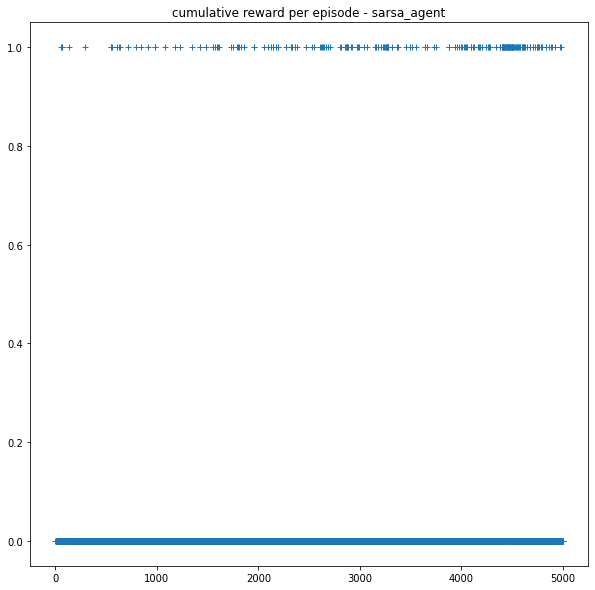

In [45]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - sarsa_agent')

In [46]:
sarsa_agent.policy

array([[0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025]])

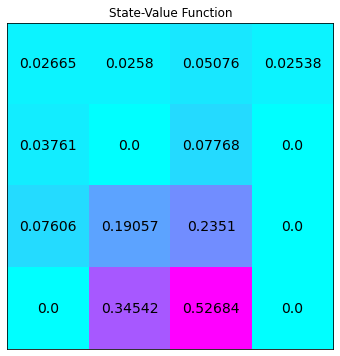

In [47]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [48]:
V.sum()

1.617871829503407

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

### TODO 6): complete Q agent

In [51]:
#TODO: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def train(self, current_state, action, reward, next_state, done):
        # TRAIN Q
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 1.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 1.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 277 - cum reward 1.0
episode: 278 - cum reward 0.0
episode: 279 - cum reward 0.0
episode: 280 - cum reward 0.0
episode: 281 - cum reward 0.0
episode: 282 - cum reward 0.0
episode: 283 - cum reward 0.0
episode: 284 - cum reward 0.0
episode: 285 - cum reward 0.0
episode: 286 - cum reward 0.0
episode: 287 - cum reward 1.0
episode: 288 - cum reward 0.0
episode: 289 - cum reward 0.0
episode: 290 - cum reward 0.0
episode: 291 - cum reward 0.0
episode: 292 - cum reward 0.0
episode: 293 - cum reward 1.0
episode: 294 - cum reward 0.0
episode: 295 - cum reward 0.0
episode: 296 - cum reward 0.0
episode: 297 - cum reward 1.0
episode: 298 - cum reward 0.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 1.0
episode: 301 - cum reward 1.0
episode: 302 - cum reward 1.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 1.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 1.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 3

episode: 581 - cum reward 0.0
episode: 582 - cum reward 1.0
episode: 583 - cum reward 0.0
episode: 584 - cum reward 0.0
episode: 585 - cum reward 0.0
episode: 586 - cum reward 0.0
episode: 587 - cum reward 0.0
episode: 588 - cum reward 1.0
episode: 589 - cum reward 1.0
episode: 590 - cum reward 0.0
episode: 591 - cum reward 1.0
episode: 592 - cum reward 1.0
episode: 593 - cum reward 0.0
episode: 594 - cum reward 0.0
episode: 595 - cum reward 0.0
episode: 596 - cum reward 0.0
episode: 597 - cum reward 0.0
episode: 598 - cum reward 1.0
episode: 599 - cum reward 1.0
episode: 600 - cum reward 0.0
episode: 601 - cum reward 1.0
episode: 602 - cum reward 1.0
episode: 603 - cum reward 0.0
episode: 604 - cum reward 1.0
episode: 605 - cum reward 1.0
episode: 606 - cum reward 0.0
episode: 607 - cum reward 0.0
episode: 608 - cum reward 1.0
episode: 609 - cum reward 1.0
episode: 610 - cum reward 1.0
episode: 611 - cum reward 0.0
episode: 612 - cum reward 1.0
episode: 613 - cum reward 1.0
episode: 6

episode: 888 - cum reward 0.0
episode: 889 - cum reward 0.0
episode: 890 - cum reward 1.0
episode: 891 - cum reward 1.0
episode: 892 - cum reward 1.0
episode: 893 - cum reward 1.0
episode: 894 - cum reward 0.0
episode: 895 - cum reward 1.0
episode: 896 - cum reward 0.0
episode: 897 - cum reward 1.0
episode: 898 - cum reward 0.0
episode: 899 - cum reward 1.0
episode: 900 - cum reward 1.0
episode: 901 - cum reward 1.0
episode: 902 - cum reward 0.0
episode: 903 - cum reward 1.0
episode: 904 - cum reward 1.0
episode: 905 - cum reward 0.0
episode: 906 - cum reward 0.0
episode: 907 - cum reward 1.0
episode: 908 - cum reward 0.0
episode: 909 - cum reward 0.0
episode: 910 - cum reward 0.0
episode: 911 - cum reward 1.0
episode: 912 - cum reward 0.0
episode: 913 - cum reward 1.0
episode: 914 - cum reward 0.0
episode: 915 - cum reward 0.0
episode: 916 - cum reward 0.0
episode: 917 - cum reward 1.0
episode: 918 - cum reward 0.0
episode: 919 - cum reward 1.0
episode: 920 - cum reward 0.0
episode: 9

episode: 1161 - cum reward 0.0
episode: 1162 - cum reward 1.0
episode: 1163 - cum reward 0.0
episode: 1164 - cum reward 1.0
episode: 1165 - cum reward 0.0
episode: 1166 - cum reward 0.0
episode: 1167 - cum reward 0.0
episode: 1168 - cum reward 1.0
episode: 1169 - cum reward 1.0
episode: 1170 - cum reward 1.0
episode: 1171 - cum reward 0.0
episode: 1172 - cum reward 0.0
episode: 1173 - cum reward 1.0
episode: 1174 - cum reward 1.0
episode: 1175 - cum reward 1.0
episode: 1176 - cum reward 0.0
episode: 1177 - cum reward 1.0
episode: 1178 - cum reward 0.0
episode: 1179 - cum reward 0.0
episode: 1180 - cum reward 0.0
episode: 1181 - cum reward 0.0
episode: 1182 - cum reward 1.0
episode: 1183 - cum reward 1.0
episode: 1184 - cum reward 0.0
episode: 1185 - cum reward 1.0
episode: 1186 - cum reward 0.0
episode: 1187 - cum reward 0.0
episode: 1188 - cum reward 0.0
episode: 1189 - cum reward 1.0
episode: 1190 - cum reward 1.0
episode: 1191 - cum reward 0.0
episode: 1192 - cum reward 0.0
episode:

episode: 1438 - cum reward 0.0
episode: 1439 - cum reward 0.0
episode: 1440 - cum reward 0.0
episode: 1441 - cum reward 1.0
episode: 1442 - cum reward 1.0
episode: 1443 - cum reward 1.0
episode: 1444 - cum reward 0.0
episode: 1445 - cum reward 0.0
episode: 1446 - cum reward 1.0
episode: 1447 - cum reward 1.0
episode: 1448 - cum reward 1.0
episode: 1449 - cum reward 1.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 1.0
episode: 1452 - cum reward 1.0
episode: 1453 - cum reward 1.0
episode: 1454 - cum reward 1.0
episode: 1455 - cum reward 1.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 0.0
episode: 1458 - cum reward 1.0
episode: 1459 - cum reward 0.0
episode: 1460 - cum reward 1.0
episode: 1461 - cum reward 0.0
episode: 1462 - cum reward 0.0
episode: 1463 - cum reward 1.0
episode: 1464 - cum reward 1.0
episode: 1465 - cum reward 1.0
episode: 1466 - cum reward 0.0
episode: 1467 - cum reward 0.0
episode: 1468 - cum reward 1.0
episode: 1469 - cum reward 0.0
episode:

episode: 1717 - cum reward 1.0
episode: 1718 - cum reward 0.0
episode: 1719 - cum reward 0.0
episode: 1720 - cum reward 0.0
episode: 1721 - cum reward 0.0
episode: 1722 - cum reward 0.0
episode: 1723 - cum reward 0.0
episode: 1724 - cum reward 1.0
episode: 1725 - cum reward 0.0
episode: 1726 - cum reward 1.0
episode: 1727 - cum reward 0.0
episode: 1728 - cum reward 0.0
episode: 1729 - cum reward 1.0
episode: 1730 - cum reward 0.0
episode: 1731 - cum reward 1.0
episode: 1732 - cum reward 0.0
episode: 1733 - cum reward 0.0
episode: 1734 - cum reward 0.0
episode: 1735 - cum reward 1.0
episode: 1736 - cum reward 1.0
episode: 1737 - cum reward 1.0
episode: 1738 - cum reward 0.0
episode: 1739 - cum reward 1.0
episode: 1740 - cum reward 1.0
episode: 1741 - cum reward 0.0
episode: 1742 - cum reward 0.0
episode: 1743 - cum reward 1.0
episode: 1744 - cum reward 1.0
episode: 1745 - cum reward 0.0
episode: 1746 - cum reward 1.0
episode: 1747 - cum reward 1.0
episode: 1748 - cum reward 0.0
episode:

episode: 1987 - cum reward 0.0
episode: 1988 - cum reward 0.0
episode: 1989 - cum reward 1.0
episode: 1990 - cum reward 0.0
episode: 1991 - cum reward 1.0
episode: 1992 - cum reward 0.0
episode: 1993 - cum reward 0.0
episode: 1994 - cum reward 1.0
episode: 1995 - cum reward 1.0
episode: 1996 - cum reward 0.0
episode: 1997 - cum reward 1.0
episode: 1998 - cum reward 0.0
episode: 1999 - cum reward 1.0
episode: 2000 - cum reward 1.0
episode: 2001 - cum reward 1.0
episode: 2002 - cum reward 1.0
episode: 2003 - cum reward 0.0
episode: 2004 - cum reward 0.0
episode: 2005 - cum reward 1.0
episode: 2006 - cum reward 1.0
episode: 2007 - cum reward 0.0
episode: 2008 - cum reward 1.0
episode: 2009 - cum reward 0.0
episode: 2010 - cum reward 1.0
episode: 2011 - cum reward 1.0
episode: 2012 - cum reward 0.0
episode: 2013 - cum reward 0.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 1.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 0.0
episode:

episode: 2280 - cum reward 1.0
episode: 2281 - cum reward 0.0
episode: 2282 - cum reward 0.0
episode: 2283 - cum reward 0.0
episode: 2284 - cum reward 0.0
episode: 2285 - cum reward 0.0
episode: 2286 - cum reward 0.0
episode: 2287 - cum reward 1.0
episode: 2288 - cum reward 1.0
episode: 2289 - cum reward 0.0
episode: 2290 - cum reward 0.0
episode: 2291 - cum reward 1.0
episode: 2292 - cum reward 1.0
episode: 2293 - cum reward 1.0
episode: 2294 - cum reward 0.0
episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 1.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 1.0
episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 1.0
episode: 2306 - cum reward 1.0
episode: 2307 - cum reward 1.0
episode: 2308 - cum reward 1.0
episode: 2309 - cum reward 0.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 1.0
episode:

episode: 2561 - cum reward 1.0
episode: 2562 - cum reward 0.0
episode: 2563 - cum reward 0.0
episode: 2564 - cum reward 0.0
episode: 2565 - cum reward 1.0
episode: 2566 - cum reward 0.0
episode: 2567 - cum reward 0.0
episode: 2568 - cum reward 1.0
episode: 2569 - cum reward 0.0
episode: 2570 - cum reward 1.0
episode: 2571 - cum reward 0.0
episode: 2572 - cum reward 0.0
episode: 2573 - cum reward 1.0
episode: 2574 - cum reward 0.0
episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 1.0
episode: 2578 - cum reward 1.0
episode: 2579 - cum reward 1.0
episode: 2580 - cum reward 0.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 1.0
episode: 2583 - cum reward 0.0
episode: 2584 - cum reward 0.0
episode: 2585 - cum reward 0.0
episode: 2586 - cum reward 1.0
episode: 2587 - cum reward 0.0
episode: 2588 - cum reward 1.0
episode: 2589 - cum reward 0.0
episode: 2590 - cum reward 1.0
episode: 2591 - cum reward 0.0
episode: 2592 - cum reward 1.0
episode:

episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 1.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 1.0
episode: 2847 - cum reward 1.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 0.0
episode: 2850 - cum reward 1.0
episode: 2851 - cum reward 0.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 1.0
episode: 2854 - cum reward 1.0
episode: 2855 - cum reward 0.0
episode: 2856 - cum reward 1.0
episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 0.0
episode: 2859 - cum reward 0.0
episode: 2860 - cum reward 1.0
episode: 2861 - cum reward 1.0
episode: 2862 - cum reward 0.0
episode: 2863 - cum reward 0.0
episode: 2864 - cum reward 0.0
episode: 2865 - cum reward 1.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 0.0
episode: 2869 - cum reward 0.0
episode: 2870 - cum reward 1.0
episode: 2871 - cum reward 0.0
episode:

episode: 3124 - cum reward 1.0
episode: 3125 - cum reward 0.0
episode: 3126 - cum reward 0.0
episode: 3127 - cum reward 1.0
episode: 3128 - cum reward 0.0
episode: 3129 - cum reward 0.0
episode: 3130 - cum reward 1.0
episode: 3131 - cum reward 1.0
episode: 3132 - cum reward 0.0
episode: 3133 - cum reward 0.0
episode: 3134 - cum reward 0.0
episode: 3135 - cum reward 1.0
episode: 3136 - cum reward 1.0
episode: 3137 - cum reward 1.0
episode: 3138 - cum reward 1.0
episode: 3139 - cum reward 1.0
episode: 3140 - cum reward 0.0
episode: 3141 - cum reward 1.0
episode: 3142 - cum reward 1.0
episode: 3143 - cum reward 0.0
episode: 3144 - cum reward 1.0
episode: 3145 - cum reward 0.0
episode: 3146 - cum reward 1.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 1.0
episode: 3149 - cum reward 0.0
episode: 3150 - cum reward 1.0
episode: 3151 - cum reward 0.0
episode: 3152 - cum reward 0.0
episode: 3153 - cum reward 0.0
episode: 3154 - cum reward 0.0
episode: 3155 - cum reward 1.0
episode:

episode: 3402 - cum reward 0.0
episode: 3403 - cum reward 1.0
episode: 3404 - cum reward 1.0
episode: 3405 - cum reward 0.0
episode: 3406 - cum reward 0.0
episode: 3407 - cum reward 0.0
episode: 3408 - cum reward 0.0
episode: 3409 - cum reward 1.0
episode: 3410 - cum reward 0.0
episode: 3411 - cum reward 0.0
episode: 3412 - cum reward 0.0
episode: 3413 - cum reward 0.0
episode: 3414 - cum reward 1.0
episode: 3415 - cum reward 1.0
episode: 3416 - cum reward 0.0
episode: 3417 - cum reward 0.0
episode: 3418 - cum reward 1.0
episode: 3419 - cum reward 0.0
episode: 3420 - cum reward 1.0
episode: 3421 - cum reward 0.0
episode: 3422 - cum reward 1.0
episode: 3423 - cum reward 0.0
episode: 3424 - cum reward 0.0
episode: 3425 - cum reward 0.0
episode: 3426 - cum reward 1.0
episode: 3427 - cum reward 0.0
episode: 3428 - cum reward 0.0
episode: 3429 - cum reward 0.0
episode: 3430 - cum reward 1.0
episode: 3431 - cum reward 0.0
episode: 3432 - cum reward 0.0
episode: 3433 - cum reward 1.0
episode:

episode: 3668 - cum reward 0.0
episode: 3669 - cum reward 0.0
episode: 3670 - cum reward 1.0
episode: 3671 - cum reward 1.0
episode: 3672 - cum reward 1.0
episode: 3673 - cum reward 0.0
episode: 3674 - cum reward 0.0
episode: 3675 - cum reward 1.0
episode: 3676 - cum reward 0.0
episode: 3677 - cum reward 0.0
episode: 3678 - cum reward 1.0
episode: 3679 - cum reward 0.0
episode: 3680 - cum reward 1.0
episode: 3681 - cum reward 0.0
episode: 3682 - cum reward 0.0
episode: 3683 - cum reward 0.0
episode: 3684 - cum reward 0.0
episode: 3685 - cum reward 1.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 1.0
episode: 3688 - cum reward 0.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 1.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 1.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 1.0
episode: 3697 - cum reward 1.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 0.0
episode:

episode: 3965 - cum reward 0.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 1.0
episode: 3970 - cum reward 1.0
episode: 3971 - cum reward 0.0
episode: 3972 - cum reward 1.0
episode: 3973 - cum reward 1.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 1.0
episode: 3976 - cum reward 0.0
episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 1.0
episode: 3979 - cum reward 1.0
episode: 3980 - cum reward 0.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 1.0
episode: 3986 - cum reward 0.0
episode: 3987 - cum reward 1.0
episode: 3988 - cum reward 0.0
episode: 3989 - cum reward 1.0
episode: 3990 - cum reward 1.0
episode: 3991 - cum reward 0.0
episode: 3992 - cum reward 0.0
episode: 3993 - cum reward 0.0
episode: 3994 - cum reward 0.0
episode: 3995 - cum reward 1.0
episode: 3996 - cum reward 1.0
episode:

episode: 4263 - cum reward 1.0
episode: 4264 - cum reward 1.0
episode: 4265 - cum reward 0.0
episode: 4266 - cum reward 0.0
episode: 4267 - cum reward 1.0
episode: 4268 - cum reward 0.0
episode: 4269 - cum reward 0.0
episode: 4270 - cum reward 1.0
episode: 4271 - cum reward 1.0
episode: 4272 - cum reward 0.0
episode: 4273 - cum reward 1.0
episode: 4274 - cum reward 0.0
episode: 4275 - cum reward 0.0
episode: 4276 - cum reward 0.0
episode: 4277 - cum reward 0.0
episode: 4278 - cum reward 0.0
episode: 4279 - cum reward 0.0
episode: 4280 - cum reward 0.0
episode: 4281 - cum reward 0.0
episode: 4282 - cum reward 0.0
episode: 4283 - cum reward 0.0
episode: 4284 - cum reward 1.0
episode: 4285 - cum reward 1.0
episode: 4286 - cum reward 0.0
episode: 4287 - cum reward 0.0
episode: 4288 - cum reward 0.0
episode: 4289 - cum reward 1.0
episode: 4290 - cum reward 1.0
episode: 4291 - cum reward 0.0
episode: 4292 - cum reward 0.0
episode: 4293 - cum reward 0.0
episode: 4294 - cum reward 0.0
episode:

episode: 4528 - cum reward 0.0
episode: 4529 - cum reward 1.0
episode: 4530 - cum reward 1.0
episode: 4531 - cum reward 0.0
episode: 4532 - cum reward 0.0
episode: 4533 - cum reward 0.0
episode: 4534 - cum reward 0.0
episode: 4535 - cum reward 1.0
episode: 4536 - cum reward 0.0
episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 1.0
episode: 4539 - cum reward 1.0
episode: 4540 - cum reward 1.0
episode: 4541 - cum reward 0.0
episode: 4542 - cum reward 1.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 0.0
episode: 4545 - cum reward 0.0
episode: 4546 - cum reward 1.0
episode: 4547 - cum reward 0.0
episode: 4548 - cum reward 0.0
episode: 4549 - cum reward 0.0
episode: 4550 - cum reward 1.0
episode: 4551 - cum reward 0.0
episode: 4552 - cum reward 0.0
episode: 4553 - cum reward 0.0
episode: 4554 - cum reward 1.0
episode: 4555 - cum reward 0.0
episode: 4556 - cum reward 0.0
episode: 4557 - cum reward 0.0
episode: 4558 - cum reward 0.0
episode: 4559 - cum reward 0.0
episode:

episode: 4809 - cum reward 0.0
episode: 4810 - cum reward 0.0
episode: 4811 - cum reward 1.0
episode: 4812 - cum reward 0.0
episode: 4813 - cum reward 0.0
episode: 4814 - cum reward 0.0
episode: 4815 - cum reward 0.0
episode: 4816 - cum reward 1.0
episode: 4817 - cum reward 0.0
episode: 4818 - cum reward 0.0
episode: 4819 - cum reward 1.0
episode: 4820 - cum reward 1.0
episode: 4821 - cum reward 0.0
episode: 4822 - cum reward 0.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 1.0
episode: 4825 - cum reward 0.0
episode: 4826 - cum reward 0.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 0.0
episode: 4829 - cum reward 1.0
episode: 4830 - cum reward 1.0
episode: 4831 - cum reward 0.0
episode: 4832 - cum reward 1.0
episode: 4833 - cum reward 1.0
episode: 4834 - cum reward 1.0
episode: 4835 - cum reward 0.0
episode: 4836 - cum reward 0.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 1.0
episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 1.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - q_agent')

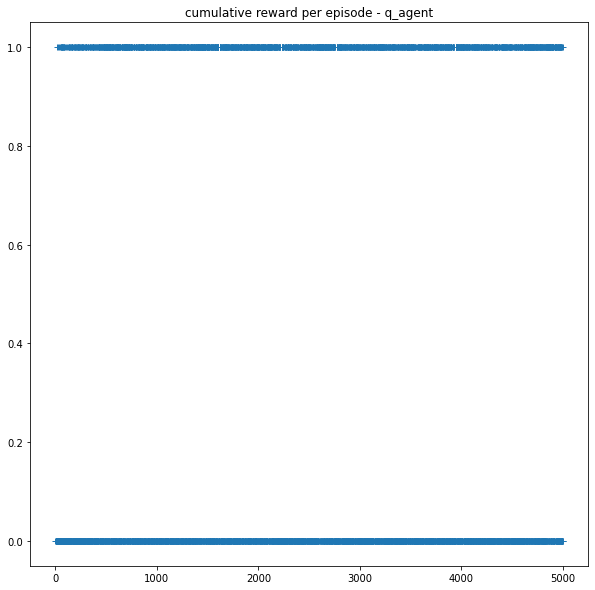

In [53]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - q_agent')

In [54]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

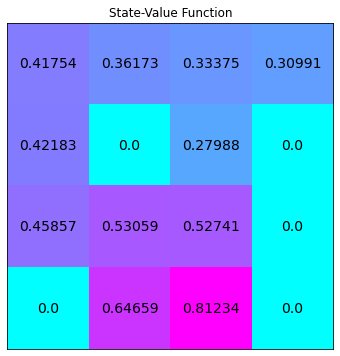

In [55]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [56]:
V.sum()

5.100116629064201

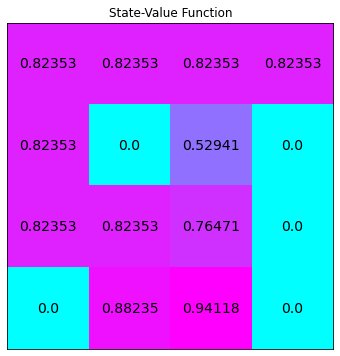

8.882351322605881

In [57]:
policy_best, V_best = value_iteration(env)
plot_values_lake(V_best)
V_best.sum()

# Question: Why we don't have the optimal policy?

In [58]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

In [59]:
q_policy_no_eps = np.zeros(q_agent.policy.shape)
q_policy_no_eps[np.arange(len(q_policy_no_eps)), q_agent.policy.argmax(axis=1)] = 1

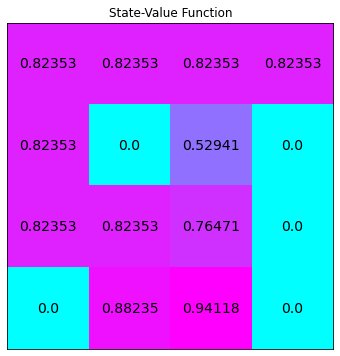

8.882351322605881

In [60]:
V = policy_evaluation(env, q_policy_no_eps)
plot_values_lake(V)
V_best.sum()

In [61]:
q_policy_no_eps

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

# Use what you built

# train/test your agent in other discrete action-space env https://gym.openai.com/envs/#toy_text

In [11]:
env = gym.make('Blackjack-v1')
env = gym.make('Taxi-v3')
...

In [ ]:
your_agent = 
nb_episode = 10
run_experiment_episode_train(env, your_agent, nb_episode, is_train=False)

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}